In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *
from blender_dataloader import get_auxs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
chunks_range = range(SEQ_LEN-1, EPISODE_LEN, SEQ_LEN)

In [21]:
run_paths = glob.glob("/home/beans/blender_membank/*/run*", recursive=True)

In [22]:
run_path = random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in chunks_range], axis=0)
maps = np.concatenate([np.load(f'{run_path}/maps_{i}.npy') for i in chunks_range], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct
#maps[:-1,:,:,:] = maps[1:,:,:,:]

targets_all = targets
targets, wp_dists, wp_z = np.split(targets_all, 3, axis=1)

aux.shape, targets.shape, wp_dists.shape, wp_z.shape, maps.shape, run_path

((1160, 12),
 (1160, 30),
 (1160, 30),
 (1160, 30),
 (1160, 120, 80, 3),
 '/home/beans/blender_membank/dataloader_04/run_13')

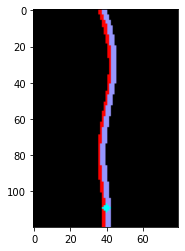

In [23]:
plt.imshow(maps[550])

In [24]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

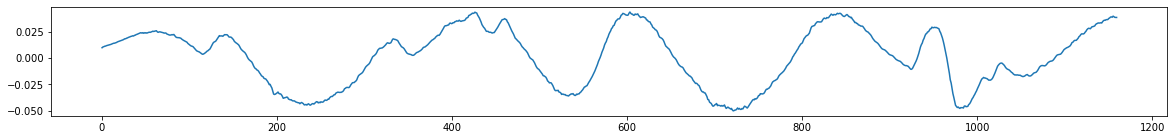

In [25]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

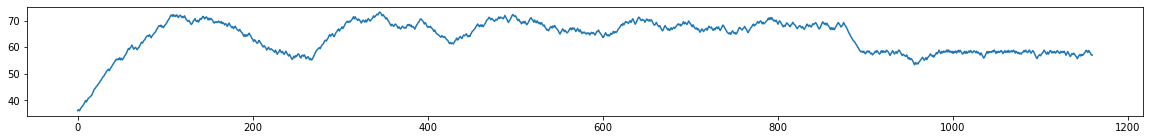

In [26]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [27]:
ix = 1000

In [28]:
t = smooth_near_wps(targets[ix])

In [29]:
xs_smoothed = np.sin(t) * wp_dists[ix]
ys_smoothed = np.cos(t) * wp_dists[ix]

xs = np.sin(targets[ix]) * wp_dists[ix]
ys = np.cos(targets[ix]) * wp_dists[ix]

In [30]:
headings_smoothed = get_headings_from_traj(t, wp_dists[ix])
headings = get_headings_from_traj(targets[ix], wp_dists[ix])

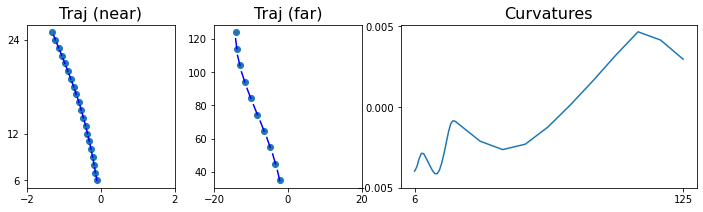

In [31]:
fig = get_pts_and_headings_fig(t, wp_dists[ix], headings_smoothed, get_curvatures_from_headings(smooth_near_wps(headings_smoothed)))

<BarContainer object of 10 artists>

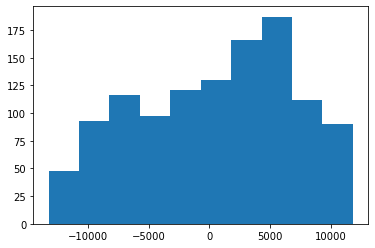

In [32]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

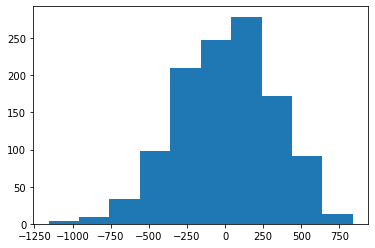

In [33]:
plt.hist(torque[1:]-torque[:-1])[2]

In [34]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [35]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    img[:,-MAP_WIDTH:,:] = maps[i]
    
    video.write(img)
    
video.release()

In [43]:
aux_model, aux_calib, aux_targets = get_auxs(pad(aux))

In [44]:
aux_model.shape, aux_calib.shape, aux_targets.shape

((1, 1160, 5), (1, 1160, 4), (1, 1160, 12))

In [46]:
from viz_utils import make_vid

imgs = np.stack([cv2.imread(f)[:,:,::-1] for f in img_paths]).astype(np.uint8)

for i in range(len(imgs)):
    imgs[i,:,-MAP_WIDTH:,:] = maps[i]

aux_vid = aux.copy()
#aux_vid[:,:2] = 0 # zeroing out pitch and yaw

run_id = "sim"
model_stem = "11.16_avg"
rollout_data = make_vid(run_id, 
                        model_stem, 
                        imgs, 
                        aux_vid, 
                        targets=targets, 
                        add_charts=False)

(1160, 30) (1160, 1, 15, 80) (1160, 1, 15, 80)
240 690 3


/home/beans/bespoke/viz_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  act_grad = act_grad/m


Made vid!


In [47]:
#combine_vids("8.9_avg", "8.9_avgTrain", "sim")

In [48]:
#p = get_viz_rollout(model_stem, imgs, aux_vid, do_gradcam=False)
#wp_angles_all, wp_headings_all, wp_curvatures_all, _, _, _, _, _ = p

In [49]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = rollout_data

(array([ 262.,  382.,  354.,  193.,  881.,  984., 1261., 1231.,  211.,
          41.]),
 array([-6.6448742e-04, -5.0002674e-04, -3.3556606e-04, -1.7110539e-04,
        -6.6447187e-06,  1.5781596e-04,  3.2227664e-04,  4.8673732e-04,
         6.5119797e-04,  8.1565866e-04,  9.8011934e-04], dtype=float32),
 <BarContainer object of 10 artists>)

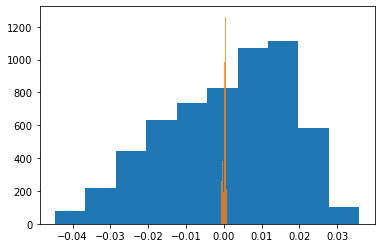

In [50]:
plt.hist(targets[:,:5].flatten())
plt.hist(wp_angles_all[:,:5].flatten(), alpha=.8)

In [22]:
obsnet_outs.shape

(1160, 3)

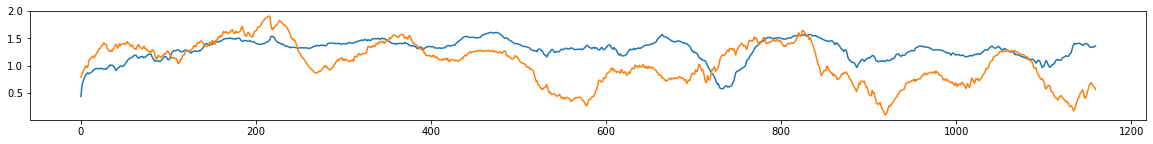

In [23]:
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,1])
plt.plot(obsnet_outs[:,2])

In [24]:
aux[0]

array([7.9585475e-01, 1.5869594e+00, 4.5101814e+01, 0.0000000e+00,
       3.2588083e-03], dtype=float32)

In [66]:
all_aux = []
all_wp_angles = []
all_wp_dists = []
all_run_paths = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/home/beans/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in chunks_range]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        wp_angles, wp_dists, wp_zs = np.split(targets, 3, axis=1)
        
        all_aux.append(aux)
        all_wp_angles.append(wp_angles)
        all_wp_dists.append(wp_dists)
        all_run_paths.append(run_path)
        
all_aux = np.stack(all_aux, axis=0)
all_wp_angles = np.stack(all_wp_angles, axis=0)
all_wp_dists = np.stack(all_wp_dists, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 229 out of 360 runs


In [67]:
all_aux.shape

(131, 1160, 12)

In [68]:
%%time
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)

CPU times: user 2.41 s, sys: 0 ns, total: 2.41 s
Wall time: 2.4 s


In [69]:
all_curvatures = get_curvatures_from_headings_batch(all_headings)

In [70]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape

((131, 1160, 30), (131, 1160, 30), (131, 1160, 30), (131, 1160, 30))

In [71]:
mm = 0
for i in range(len(all_curvatures)):
    m = abs(all_curvatures[i]).max()
    if m > .05:
        print(i, m)
        mm += 1

2 0.07596612
3 0.06857008
5 0.14184648
10 0.050288796
20 0.17893285
26 0.05741805
27 0.09617841
30 0.06293393
35 0.064626485
47 0.06733638
55 0.16925102
58 0.2082355
59 0.063932896
60 0.05950311
71 0.061145395
80 0.075238764
81 0.11376691
88 0.09564525
89 0.08541423
91 0.0864405
95 0.1051655
96 0.07432908
104 0.10633233
106 0.21012303
110 0.05212757
111 0.0781908
115 0.073744446
117 0.20125234
119 0.06526125
122 0.06086284
129 0.0667564


In [72]:
all_run_paths[58]

'/home/beans/blender_membank/dataloader_05/run_4'

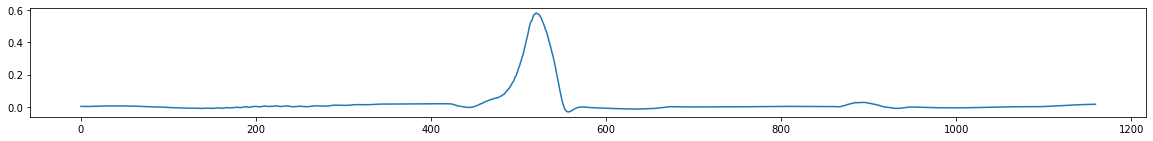

In [73]:
plt.figure(figsize=(20,2))
plt.plot(all_wp_angles[58,:,0])

<BarContainer object of 40 artists>

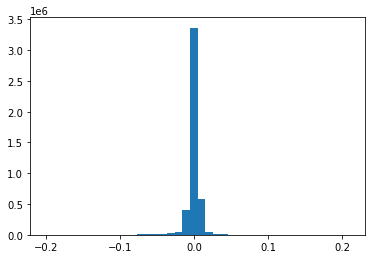

In [74]:
plt.hist(all_curvatures[:,:,:].flatten(), bins=40)[2]

In [75]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_wp_angles[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

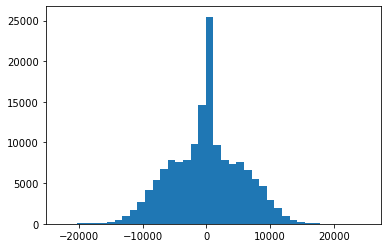

In [76]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

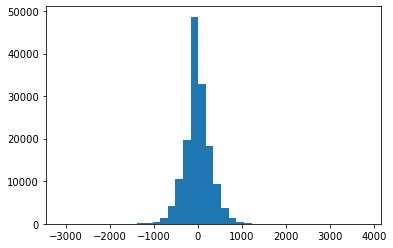

In [77]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [78]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(1319.952859249423, 19161.16248199964)

In [79]:
mean_dists = abs(all_wp_dists).mean(axis=0).mean(0)
mean_dists

array([  6.0007796,   7.000375 ,   7.999779 ,   8.99894  ,   9.997821 ,
        10.996389 ,  11.994569 ,  12.992344 ,  13.989657 ,  14.986466 ,
        15.982787 ,  16.97856  ,  17.97379  ,  18.968496 ,  19.962667 ,
        20.956306 ,  21.949467 ,  22.942097 ,  23.93426  ,  24.92593  ,
        34.820374 ,  44.681522 ,  54.51386  ,  64.31846  ,  74.09542  ,
        83.845085 ,  93.56889  , 103.268456 , 112.9458   , 122.60376  ],
      dtype=float32)

<BarContainer object of 40 artists>

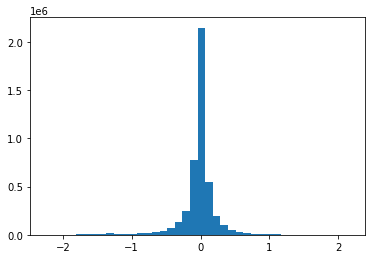

In [80]:
plt.hist(all_headings.flatten(), bins=40)[2]

In [81]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.03111181, 0.03618466, 0.04120879, 0.04629128, 0.05143179,
       0.05662476, 0.06186062, 0.06713659, 0.07243928, 0.07774755,
       0.08304299, 0.08831067, 0.09353578, 0.09870192, 0.10379868,
       0.10882027, 0.11376556, 0.11863533, 0.12342887, 0.12793624,
       0.16911736, 0.20534694, 0.23607549, 0.26210722, 0.28397518,
       0.30235887, 0.3174051 , 0.32928354, 0.3385019 , 0.34343708],
      dtype=float32)

In [82]:
mean_headings[-1] / mean_headings[0]

11.0388

In [83]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01540798, 0.01798773, 0.02054555, 0.02309263, 0.0256376 ,
       0.02818577, 0.03073909, 0.03329917, 0.03586567, 0.03843804,
       0.04101453, 0.04359289, 0.0461707 , 0.04874605, 0.05131625,
       0.05387906, 0.05643169, 0.05897278, 0.06150095, 0.06401511,
       0.0880814 , 0.10984191, 0.12932593, 0.146703  , 0.16209604,
       0.17565918, 0.18755753, 0.19792497, 0.20690149, 0.2147161 ],
      dtype=float32)

In [84]:
mean_angles[-1] / mean_angles[0]

13.935384

In [85]:
mean_angles[0] / .015

1.027198632558187

<BarContainer object of 40 artists>

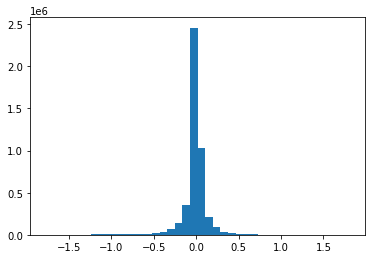

In [86]:
plt.hist(all_wp_angles.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

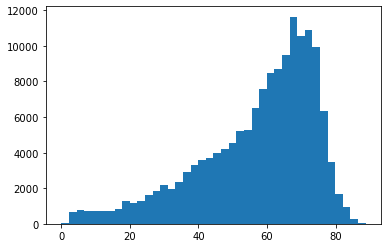

In [87]:
# speed
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

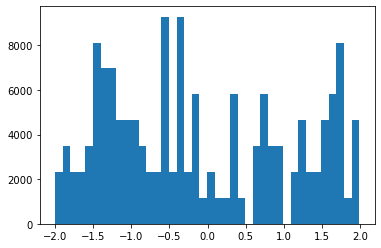

In [88]:
# pitch
plt.hist(all_aux[:,:,0].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

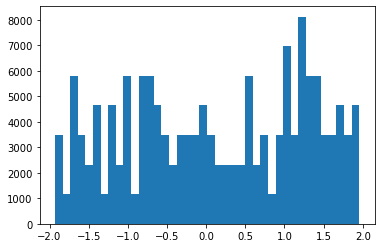

In [89]:
# yaw
plt.hist(all_aux[:,:,1].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

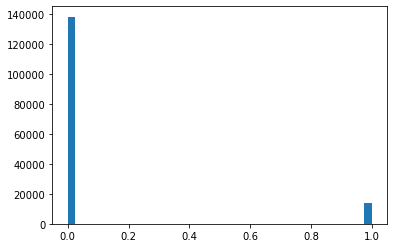

In [90]:
# approaching stop
plt.hist(all_aux[:,:,AUX_APPROACHING_STOP_IX].flatten(), bins=40)[2]

In [91]:
all_aux.shape

(131, 1160, 12)

<BarContainer object of 40 artists>

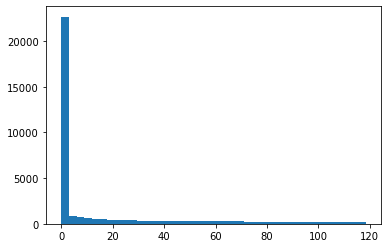

In [92]:
# stop dist
a = all_aux[:,:,AUX_STOP_DIST_IX].flatten()
a = a[a<1e6]
plt.hist(a, bins=40)[2]

<BarContainer object of 40 artists>

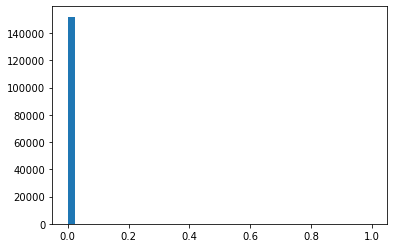

In [94]:
# stopped
a = all_aux[:,:,AUX_STOPPED_IX].flatten()
plt.hist(a, bins=40)[2]

In [95]:
a.sum()

24.0

<BarContainer object of 40 artists>

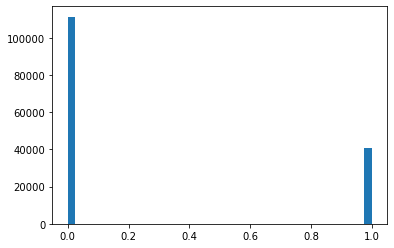

In [96]:
# lead car
a = all_aux[:,:,AUX_HAS_LEAD_IX].flatten()
plt.hist(a, bins=40)[2]

<BarContainer object of 40 artists>

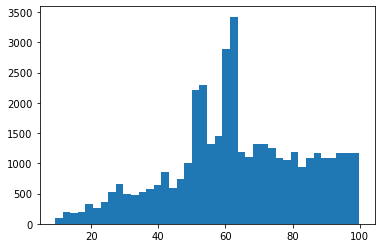

In [97]:
# lead dist
a = all_aux[:,:,AUX_LEAD_DIST_IX].flatten()
a = a[a<1e6]
plt.hist(a, bins=40)[2]